<a href="https://colab.research.google.com/github/usUpal/dog-breed-prediction/blob/main/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"usupal","key":"c5652199304479ce6cc57def76400ba2"}'}

In [2]:
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
# Searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  
---------------------------------  ----------------------  -----  -------------------  -------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05             80  


In [6]:
# Downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 691M/691M [00:07<00:00, 95.4MB/s]

/content


In [7]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

# Imports

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [11]:
# Read the labels.csv file and checking shape and records
labels_all = pd.read_csv('/content/dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head(20)

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [12]:
# visualize each number of breeds
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head(5)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [14]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','afghan_hound']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head(6)

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound
5,161,03dc61595ad9dbf49e3998cf586ca8cb,scottish_deerhound


In [16]:
# creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# one hot encoding
Y_data = label_binarize(labels['breed'], classes=CLASS_NAMES)

# reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis= 0)
  X_data[i] = x/255.0

# print train image & one hot encoding shape and size
print(f'\nTrain Image Shape: {X_data.shape} & size: {X_data.size}')
print(f'one hot encoded shape: {Y_data.shape} & size: {Y_data.size}')

100%|██████████| 359/359 [00:01<00:00, 232.65it/s]


Train Image Shape: (359, 224, 224, 3) & size: 54039552
one hot encoded shape: (359, 3) & size: 1077


In [25]:
# Building the model
model = Sequential()

model.add(Conv2D(filters= 64, kernel_size=(5,5), activation='relu', input_shape =(224, 224, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 32, kernel_size=(3,3), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 16, kernel_size=(7,7), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 8, kernel_size=(5,5), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(len(CLASS_NAMES), activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer =Adam (0.0001), metrics= ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 108, 108, 32)      18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 48, 48, 16)        25104     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 20, 20, 8)        

In [26]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)

# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [27]:
# Training Model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size= batch_size, epochs=epochs, validation_data=(X_val, Y_val))

Epoch 1/100
3/3 [==============================] - 37s 9s/step - loss: 4.8839 - accuracy: 0.3488 - val_loss: 4.8625 - val_accuracy: 0.3077
Epoch 2/100
3/3 [==============================] - 33s 9s/step - loss: 4.8493 - accuracy: 0.3566 - val_loss: 4.8292 - val_accuracy: 0.3538
Epoch 3/100
3/3 [==============================] - 35s 10s/step - loss: 4.8208 - accuracy: 0.3643 - val_loss: 4.7994 - val_accuracy: 0.4308
Epoch 4/100
3/3 [==============================] - 34s 9s/step - loss: 4.7947 - accuracy: 0.3798 - val_loss: 4.7716 - val_accuracy: 0.3692
Epoch 5/100
3/3 [==============================] - 34s 9s/step - loss: 4.7677 - accuracy: 0.3760 - val_loss: 4.7424 - val_accuracy: 0.3692
Epoch 6/100
3/3 [==============================] - 34s 9s/step - loss: 4.7386 - accuracy: 0.3915 - val_loss: 4.7133 - val_accuracy: 0.4000
Epoch 7/100
3/3 [==============================] - 34s 9s/step - loss: 4.7087 - accuracy: 0.4225 - val_loss: 4.6843 - val_accuracy: 0.4000
Epoch 8/100
3/3 [=========

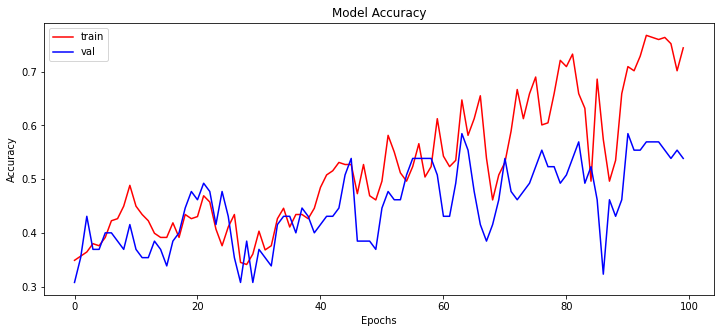

In [28]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [29]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 1s 130ms/step - loss: 3.2088 - accuracy: 0.5278
Accuracy over the test set: 
  52.78 %


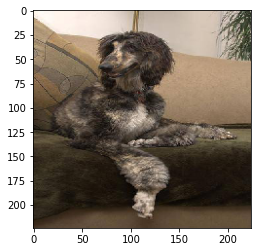

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [30]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])